# Toxic Comment Classification Challenge
# Data Augmentation

## Introduction

In our exploratory data analysis (EDA), we observed a significant class imbalance, particularly in the toxic subcategories of threat, identity hate, and severe toxic. To address this imbalance, we employ data augmentation techniques. One effective method is backtranslation, which involves translating text to another language and back to the original language. This process generates paraphrased versions of the original text, helping to artificially increase the dataset size for the underrepresented classes. By doing so, we aim to provide more balanced training data, which can improve model performance on these minority classes.

## Classes Overview

### Loading the Data

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from utils import plot_class_distribution
from utils import preprocess_text, clean_text_for_bert, deduplicate_rows
from utils import load_translation_model, augment_data_in_batches

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MiestoMeska\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MiestoMeska\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
cleaned_data = pd.read_csv('../data/cleaned/train_cleaned_comments.csv')
print(cleaned_data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  \
0             0        0       0       0              0   
1             0        0       0       0              0   
2             0        0       0       0              0   
3             0        0       0       0              0   
4             0        0       0       0              0   

                                        cleaned_text  
0  explanation why the edits made under my userna...  
1  daww he match this background colour i am see

In [4]:
cleaned_data = cleaned_data.drop(columns=['comment_text'])
cleaned_data = deduplicate_rows(cleaned_data)

df_threat = cleaned_data[(cleaned_data['threat'] == 1)]
df_severe_toxic = cleaned_data[(cleaned_data['severe_toxic'] == 1)]
df_identity_hate = cleaned_data[(cleaned_data['identity_hate'] == 1)]

Initial DataFrame shape: (159571, 8)
DataFrame shape after deduplication: (158004, 8)


In [5]:
print(df_threat.sample(5))
print(df_severe_toxic.sample(5))
print(df_identity_hate.sample(5))

                      id  toxic  severe_toxic  obscene  threat  insult  \
38221   6604792fc33aabb1      1             0        1       1       1   
138147  e34101f638fc1d63      1             0        0       1       0   
28709   4c0b851462566f1d      1             0        1       1       1   
4733    0c8c45cc1a037baf      1             0        0       1       0   
97089   0772d02b3dacffd4      1             0        0       1       1   

        identity_hate                                       cleaned_text  
38221               0  may god spare your soul you are going to hell ...  
138147              0  your impending death because of your libel and...  
28709               0  if you fucking message me again i am going to ...  
4733                0  why are you still here can you not find anythi...  
97089               0                  fdsgdfgfd why do not you die talk  
                      id  toxic  severe_toxic  obscene  threat  insult  \
4008    0ab6d9ce8ee20cbf      1

### Class Distribution of the Data

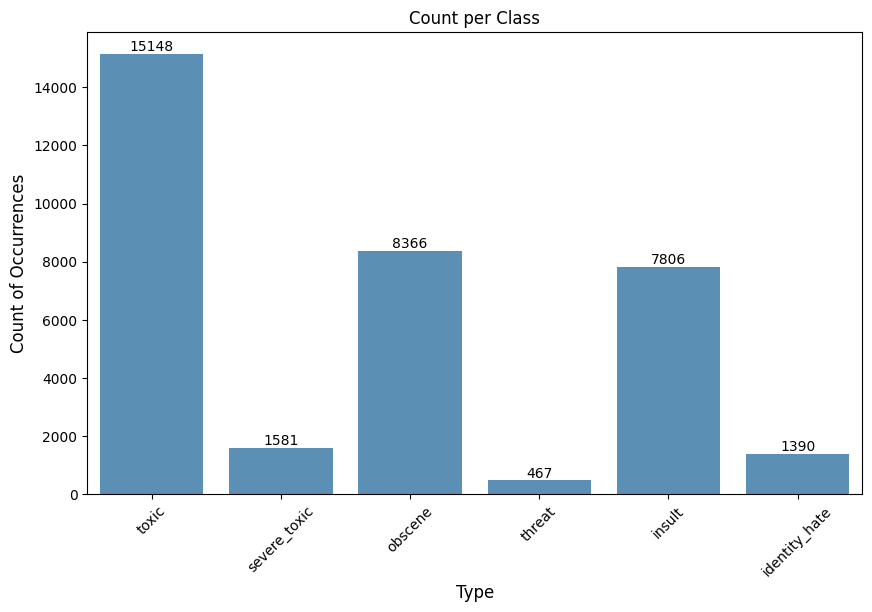

In [8]:
toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_toxic_class_dist = cleaned_data[toxicity_columns].sum()

plot_class_distribution(df_toxic_class_dist)

The bar chart displays the count of occurrences for each type of toxic comment in the dataset. The toxic class has the highest frequency with 15,148 occurrences, followed by obscene with 8,366 and insult with 7,806. The classes severe toxic, identity hate, and threat are significantly underrepresented, with 1,581, 1,390, and 467 occurrences, respectively. This imbalance highlights the need for data augmentation, particularly for the minority classes such as severe toxic, identity hate, and threat, to ensure the model performs well across all categories.

### Class Distribution Analysis

In this section, we explore the distribution of each toxicity class and analyze how often comments are labeled with multiple toxicity types. Understanding the overlap between different toxic categories is crucial to better grasp the complexity of the dataset and to tailor our model's training process.

#### Threat Class

In [5]:
df_threat = deduplicate_rows(df_threat)

Initial DataFrame shape: (467, 8)
DataFrame shape after deduplication: (467, 8)


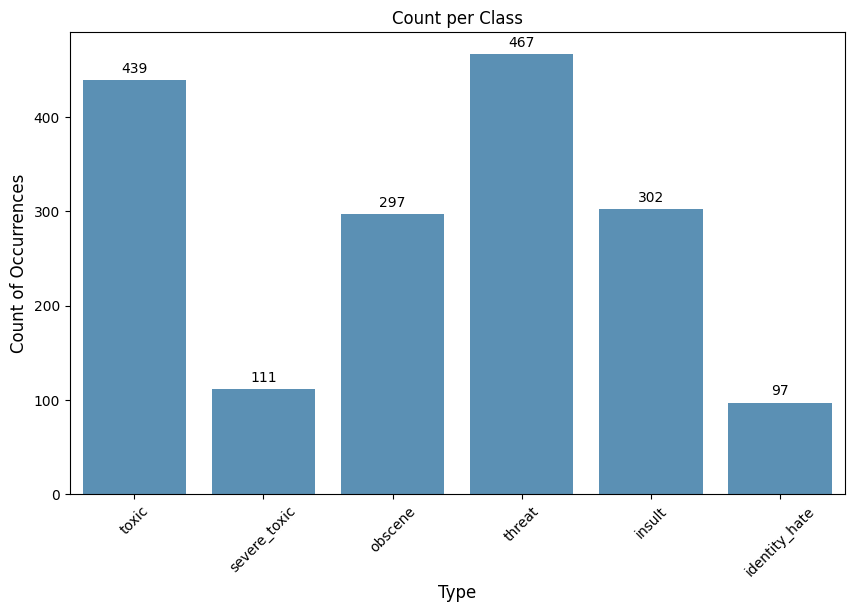

In [9]:
df_threat_class_dist = df_threat[toxicity_columns].sum()

plot_class_distribution(df_threat_class_dist)

#### Severe Toxic Class

In [6]:
df_severe_toxic = deduplicate_rows(df_severe_toxic)

Initial DataFrame shape: (1581, 8)
DataFrame shape after deduplication: (1581, 8)


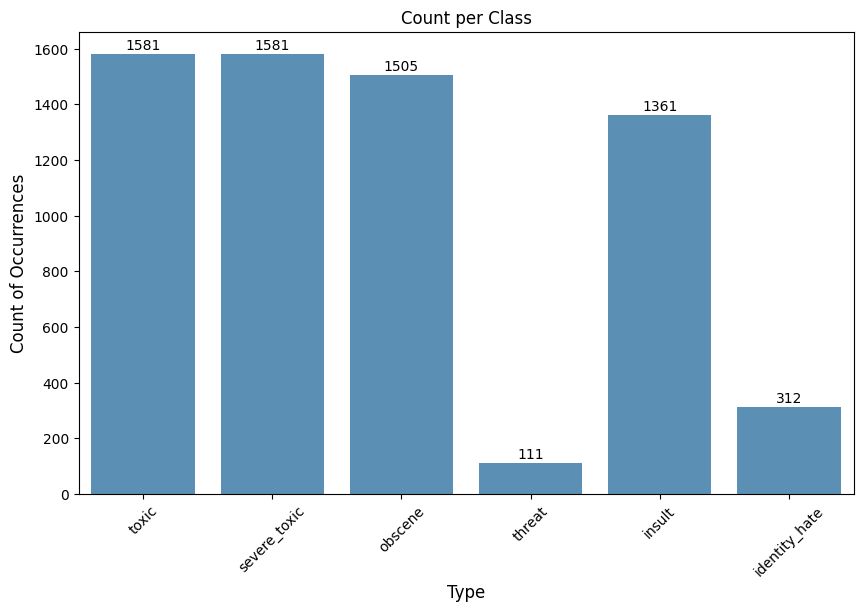

In [10]:
df_severe_toxic_class_dist = df_severe_toxic[toxicity_columns].sum()

plot_class_distribution(df_severe_toxic_class_dist)

#### Identity Hate Class

In [7]:
df_identity_hate = deduplicate_rows(df_identity_hate)

Initial DataFrame shape: (1390, 8)
DataFrame shape after deduplication: (1390, 8)


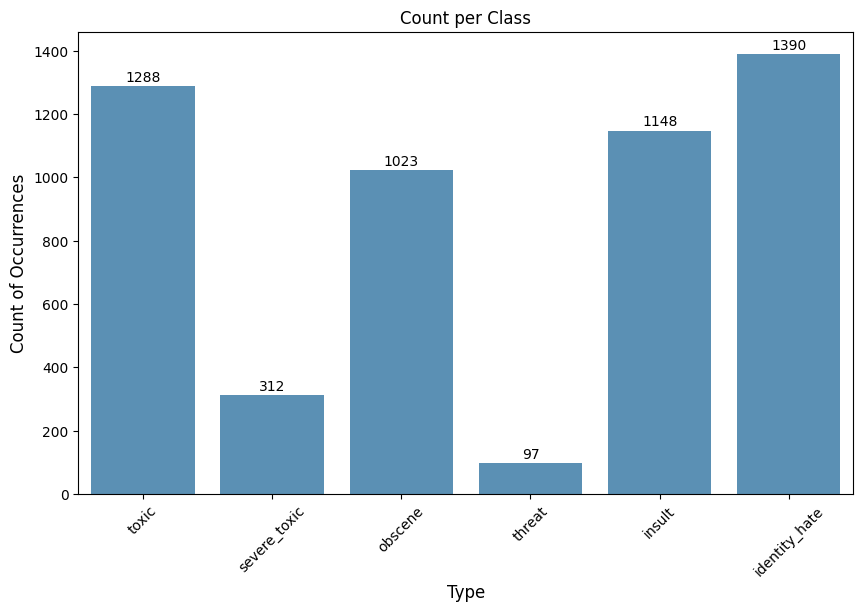

In [11]:
df_identity_hate_class_dist = df_identity_hate[toxicity_columns].sum()

plot_class_distribution(df_identity_hate_class_dist)

### Conclusion

The distribution analysis reveals significant class imbalance, with classes like threat, identity hate, and severe toxic being particularly underrepresented. Furthermore, there is a noticeable overlap between some categories, where comments labeled as toxic also often carry labels such as obscene or insult. These findings highlight the need for targeted data augmentation, especially for the minority classes, and the importance of multi-label classification in capturing the intricate relationships between different forms of toxicity.

## Augmentation using Backtranslation

To address class imbalance, we use backtranslation to augment underrepresented classes like threat, identity hate, and severe toxic. By translating text to another language and back, we generate paraphrased versions of comments, enhancing the dataset with diverse examples. This helps balance the training data and improves model performance on these minority classes.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_en_fr, tokenizer_en_fr = load_translation_model('en', 'fr', device)
model_fr_en, tokenizer_fr_en = load_translation_model('fr', 'en', device)


### Threat Class Backtranslation

In [13]:
batch_size = 12

df_threat_augmented = augment_data_in_batches(df_threat, batch_size, model_en_fr, tokenizer_en_fr, model_fr_en, tokenizer_fr_en, device)

Back Translating: 100%|████████████████████████████████████████████████████████████| 467/467 [07:31<00:00,  1.03rows/s]


In [15]:
df_threat_augmented.loc[:, 'augmented_text'] = df_threat_augmented['augmented_text'].apply(clean_text_for_bert)
df_threat_augmented.sample(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,augmented_text
71866,c06cd5be020445e4,1,1,1,1,1,0,i will find you in real life and kill you i wi...,i will find you in real life and kill you i wi...
5569,0ee454e997194378,1,1,1,1,1,0,how dare you send me such abuse you fucking co...,how dare you send me such an abuse you fucking...
100222,188ec3b7baf66495,1,1,1,1,1,1,urgent mind yo own fucken buisiness stop fucke...,you have an urgent mind you do not have to fuc...
140018,ed4b78fe8db94a69,1,0,1,1,1,0,oh not you again and so after the block ha exp...,oh not you again and then after the block ha e...
74368,c6f9224524a5bedc,1,0,1,1,1,0,for what you did and wrote about me you are a ...,for what you have done and written about me yo...


In [16]:
different_rows = df_threat_augmented[df_threat_augmented['cleaned_text'] != df_threat_augmented['augmented_text']]
cleaned_df = different_rows[['id', 'cleaned_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
augmented_df = different_rows[['augmented_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
augmented_df['id'] = 'aug_threat_' + different_rows['id'].astype(str)
augmented_df.rename(columns={'augmented_text': 'cleaned_text'}, inplace=True)
df_threat_augmented_final = pd.concat([cleaned_df, augmented_df], ignore_index=True)
df_threat_augmented_final = df_threat_augmented_final.drop_duplicates(subset='cleaned_text', keep='first').reset_index(drop=True)

print(df_threat_augmented_final.head())

                 id                                       cleaned_text  toxic  \
0  003217c3eb469ba9  hi i am back again last warning stop undoing m...      1   
1  006b94add72ed61c  i think that your a fagget get a oife and burn...      1   
2  0199d6af27b715f3  i am also a sock puppet of this accountsuprise...      1   
3  02230885017a50c5  fuck you smith please have me notified when yo...      1   
4  02c6e41e4b317ac3  would not be the first time bitch fuck you i w...      1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       1       0              0  
1             0        1       1       1              1  
2             0        0       1       0              0  
3             0        1       1       1              0  
4             1        1       1       1              1  


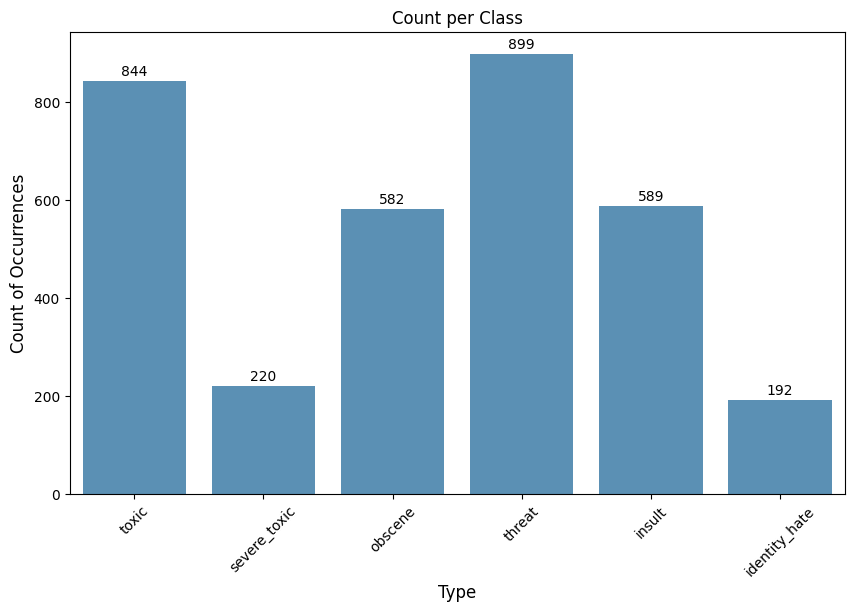

In [19]:
df_threat_augmented_final_dist = df_threat_augmented_final[toxicity_columns].sum()

plot_class_distribution(df_threat_augmented_final_dist)

### Identity Hate Class Backtranslation

In [20]:
df_identity_hate_augmented = augment_data_in_batches(df_identity_hate, batch_size, model_en_fr, tokenizer_en_fr, model_fr_en, tokenizer_fr_en, device)

Back Translating: 100%|██████████████████████████████████████████████████████████| 1390/1390 [23:03<00:00,  1.00rows/s]


In [21]:
df_identity_hate_augmented.loc[:, 'augmented_text'] = df_identity_hate_augmented['augmented_text'].apply(clean_text_for_bert)
df_identity_hate_augmented.sample(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,augmented_text
115011,6704d3a8dcfe9389,1,0,1,0,1,1,i hate you you stupid little midget,i hate you little dwarf
136075,d7d04334ece5f980,1,0,1,0,1,1,wow avatar is gay yes i do mean this movie is ...,wow avatar is gay yes i mean this movie is gay...
110499,4f2f5a375a50d8df,1,0,1,0,1,1,hmmm i notice on looking at this page history ...,i noticed looking at the history of this page ...
16390,2b324568e82d54ae,1,1,1,0,1,1,hey hey faggot are you dead or are you watchin...,hey hey faggot are you dead or watch your moth...
73682,c52bef26cbc5833c,1,1,1,0,1,1,shitty nigger fuck i love dr you shitty nigger...,shit nigger fuck i love dr dirty nigger fuck i...


In [22]:
different_rows = df_identity_hate_augmented[df_identity_hate_augmented['cleaned_text'] != df_identity_hate_augmented['augmented_text']]
cleaned_df = different_rows[['id', 'cleaned_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
augmented_df = different_rows[['augmented_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
augmented_df['id'] = 'aug_hate_' + different_rows['id'].astype(str)
augmented_df.rename(columns={'augmented_text': 'cleaned_text'}, inplace=True)
df_identity_hate_augmented_final = pd.concat([cleaned_df, augmented_df], ignore_index=True)
df_identity_hate_augmented_final = df_identity_hate_augmented_final.drop_duplicates(subset='cleaned_text', keep='first').reset_index(drop=True)

print(df_identity_hate_augmented_final.head())

                 id                                       cleaned_text  toxic  \
0  001810bf8c45bf5f  you are gay or antisemmitian archangel white t...      1   
1  00472b8e2d38d1ea            a pair of jewhating weiner nazi schmuck      1   
2  006b94add72ed61c  i think that your a fagget get a oife and burn...      1   
3  008e0818dde894fb  kill all nigger i have hard that others have s...      1   
4  0097dd5c29bf7a15  you r a tw fuck off you gay boyyou r smellyfuc...      1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        1       0       1              1  
1             0        1       0       1              1  
2             0        1       1       1              1  
3             0        1       0       1              1  
4             0        1       0       1              1  


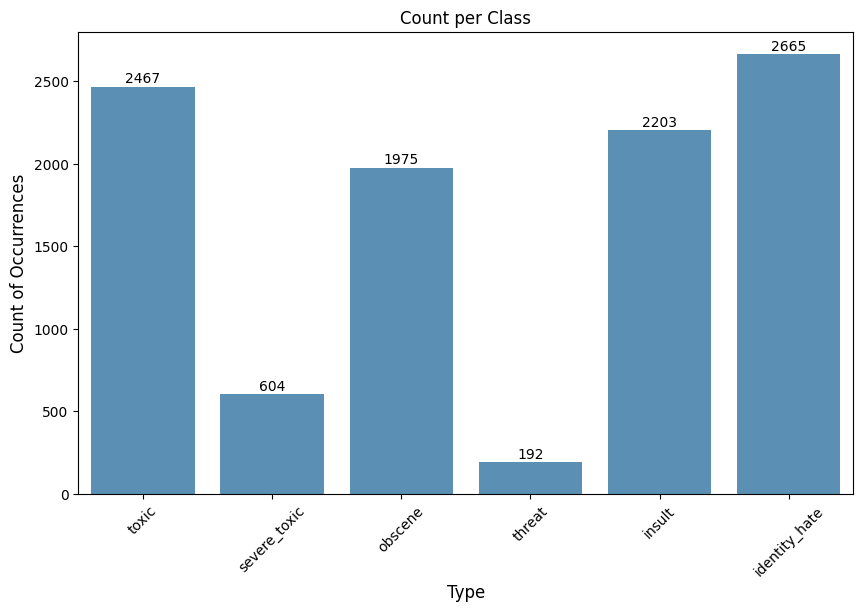

In [23]:
df_identity_hate_augmented_final_dist = df_identity_hate_augmented_final[toxicity_columns].sum()

plot_class_distribution(df_identity_hate_augmented_final_dist)

### Severe Toxic Class Backtranslation

In [24]:
df_severe_toxic_augmented = augment_data_in_batches(df_severe_toxic, batch_size, model_en_fr, tokenizer_en_fr, model_fr_en, tokenizer_fr_en, device)

Back Translating: 100%|██████████████████████████████████████████████████████████| 1581/1581 [30:58<00:00,  1.18s/rows]


In [25]:
df_severe_toxic_augmented.loc[:, 'augmented_text'] = df_severe_toxic_augmented['augmented_text'].apply(clean_text_for_bert)
df_severe_toxic_augmented.sample(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,augmented_text
142719,fb52ae8c4b4b72cf,1,1,0,0,0,0,not set in new york why when i deleted the cat...,not put in new york why when i deleted the cat...
52373,8c274602b922cf84,1,1,1,0,1,0,fuck you all go to hell,all go to hell
38997,6803afa9a0e0089b,1,1,1,0,1,0,fuck off you assfuck off you assfuck off you a...,fuck you fuck you fuck you fuck you fuck you f...
142348,f9634e62820eed00,1,1,1,0,1,0,fuck you fuck you you stupid bastard i do not ...,i do not care what you say
109421,4935679c7a383607,1,1,1,0,1,1,your country is shit all it doe is pollute the...,your country is shitty all it doe is pollute t...


In [26]:
different_rows = df_severe_toxic_augmented[df_severe_toxic_augmented['cleaned_text'] != df_severe_toxic_augmented['augmented_text']]
cleaned_df = different_rows[['id', 'cleaned_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
augmented_df = different_rows[['augmented_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
augmented_df['id'] = 'aug_sevtox_' + different_rows['id'].astype(str)
augmented_df.rename(columns={'augmented_text': 'cleaned_text'}, inplace=True)
df_severe_toxic_augmented_final = pd.concat([cleaned_df, augmented_df], ignore_index=True)
df_severe_toxic_augmented_final = df_severe_toxic_augmented_final.drop_duplicates(subset='cleaned_text', keep='first').reset_index(drop=True)

print(df_severe_toxic_augmented_final.head())

                 id                                       cleaned_text  toxic  \
0  0002bcb3da6cb337       cocksucker before you piss around on my work      1   
1  0020e7119b96eeeb  stupid peace of shit stop deleting my stuff as...      1   
2  006e87872c8b370c   you are a stupid fuck and your mother cunt stink      1   
3  01208d2b76624130                            hi i am a fucking bitch      1   
4  018663f910e0bfe6  what a motherfucking piece of crap those fuckh...      1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             1        1       0       1              0  
1             1        1       0       1              0  
2             1        1       0       1              0  
3             1        1       0       1              0  
4             1        1       0       1              0  


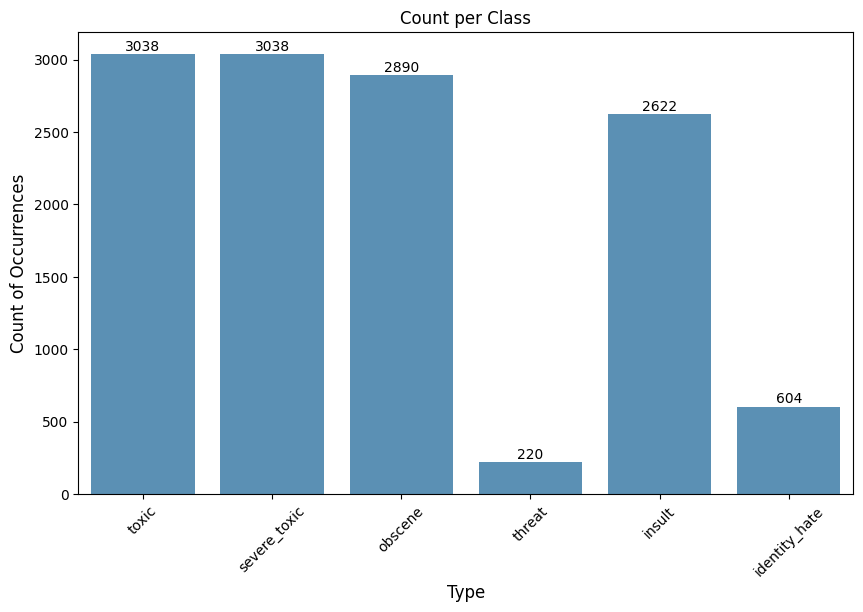

In [27]:
df_severe_toxic_augmented_final_dist = df_severe_toxic_augmented_final[toxicity_columns].sum()

plot_class_distribution(df_severe_toxic_augmented_final_dist)

### Merging the Original Data with the Augmented Data 

In [28]:
df_combined_augmented = pd.concat([
    df_threat_augmented_final,
    df_identity_hate_augmented_final,
    df_severe_toxic_augmented_final
], ignore_index=True)

df_combined_augmented = df_combined_augmented.drop_duplicates(subset='cleaned_text', keep='first').reset_index(drop=True)


                 id                                       cleaned_text  toxic  \
0  003217c3eb469ba9  hi i am back again last warning stop undoing m...      1   
1  006b94add72ed61c  i think that your a fagget get a oife and burn...      1   
2  0199d6af27b715f3  i am also a sock puppet of this accountsuprise...      1   
3  02230885017a50c5  fuck you smith please have me notified when yo...      1   
4  02c6e41e4b317ac3  would not be the first time bitch fuck you i w...      1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       1       0              0  
1             0        1       1       1              1  
2             0        0       1       0              0  
3             0        1       1       1              0  
4             1        1       1       1              1  


In [29]:
print(df_combined_augmented.head())

                 id                                       cleaned_text  toxic  \
0  003217c3eb469ba9  hi i am back again last warning stop undoing m...      1   
1  006b94add72ed61c  i think that your a fagget get a oife and burn...      1   
2  0199d6af27b715f3  i am also a sock puppet of this accountsuprise...      1   
3  02230885017a50c5  fuck you smith please have me notified when yo...      1   
4  02c6e41e4b317ac3  would not be the first time bitch fuck you i w...      1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       1       0              0  
1             0        1       1       1              1  
2             0        0       1       0              0  
3             0        1       1       1              0  
4             1        1       1       1              1  


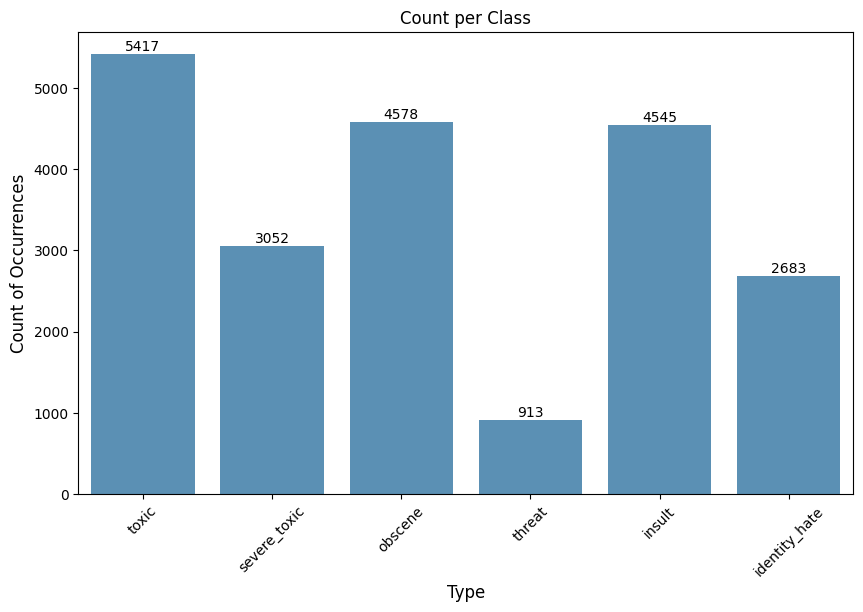

In [30]:
df_combined_augmented_dist = df_combined_augmented[toxicity_columns].sum()

plot_class_distribution(df_combined_augmented_dist)

In [31]:
augmented_cleaned_data = pd.concat([cleaned_data, df_combined_augmented], ignore_index=True)

augmented_cleaned_data = augmented_cleaned_data.drop_duplicates(subset='cleaned_text', keep='first').reset_index(drop=True)

print(augmented_cleaned_data.head())

                 id  toxic  severe_toxic  obscene  threat  insult  \
0  0000997932d777bf      0             0        0       0       0   
1  000103f0d9cfb60f      0             0        0       0       0   
2  000113f07ec002fd      0             0        0       0       0   
3  0001b41b1c6bb37e      0             0        0       0       0   
4  0001d958c54c6e35      0             0        0       0       0   

   identity_hate                                       cleaned_text  
0              0  explanation why the edits made under my userna...  
1              0  daww he match this background colour i am seem...  
2              0  hey man i am really not trying to edit war it ...  
3              0  more i cannot make any real suggestion on impr...  
4              0  you sir are my hero any chance you remember wh...  


In [ ]:
augmented_cleaned_data_dist = augmented_cleaned_data[toxicity_columns].sum()

#### Conclusions

While most classes have increased in size, threat remains underrepresented with 913 occurrences compared to other classes like toxic, obscene, and insult, which all exceed 4,000 occurrences. This outcome reflects the intertwined nature of these classes—backtranslation not only augments the target class but also affects related classes, leading to an increase in their occurrences. Despite this, the augmentation has successfully improved class representation, and further steps might be necessary to focus on threat specifically to better balance the dataset.

### Second Pass of Backtranslation for Threat Class

In this phase, we focus exclusively on augmenting the underrepresented threat class through a second pass of backtranslation. By generating additional paraphrased examples specifically for threat, we aim to further balance its occurrence relative to other classes. This targeted approach ensures that the threat class receives adequate representation in the training data, helping to improve model performance on this challenging category.

In [42]:
df_threat_aug2 = augmented_cleaned_data[(augmented_cleaned_data['threat'] == 1)]

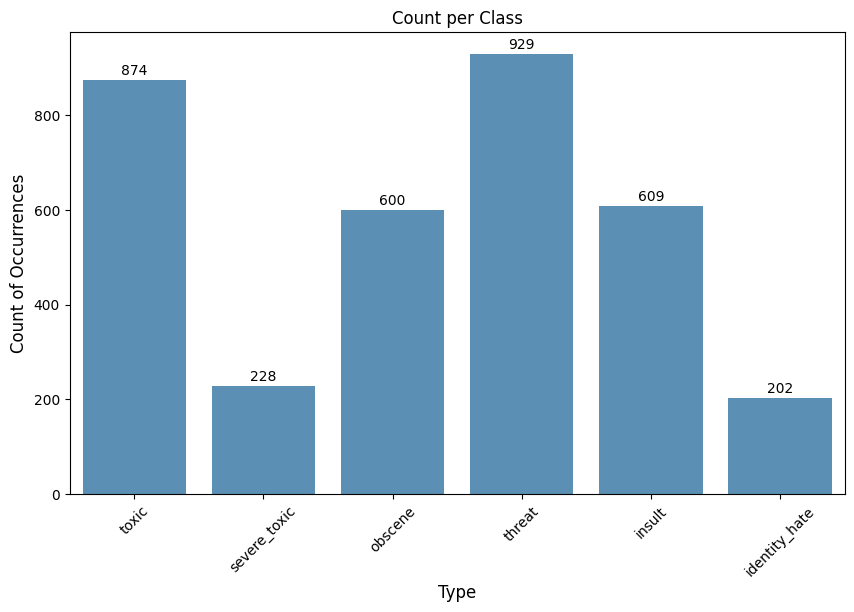

In [43]:
df_threat_aug2_dist = df_threat_aug2[toxicity_columns].sum()

plot_class_distribution(df_threat_aug2_dist)

In [ ]:
model_en_de, tokenizer_en_de = load_translation_model('en', 'de', device)
model_de_en, tokenizer_de_en = load_translation_model('de', 'en', device)

In [ ]:
batch_size = 12

df_threat_augmented_de = augment_data_in_batches(df_threat_aug2, batch_size, model_en_de, tokenizer_en_de, model_de_en, tokenizer_de_en, device)

In [47]:
df_threat_augmented_de.loc[:, 'augmented_text'] = df_threat_augmented_de['augmented_text'].apply(clean_text_for_bert)
df_threat_augmented_de.sample(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,augmented_text
158412,augmented_340aa679f3c4f757,1,0,1,1,1,0,i am trying to help you fuck up while you are ...,i am trying to help you fuck up while you are ...
48927,83820b7546533a1a,1,0,1,1,1,0,i am going to punch you in the ovary that is r...,i am going to hit you in the ovary that is rig...
13623,2416f05064cc2919,1,1,1,1,1,0,hope your head get cut off and someone wips th...,i hope your head is cut off and someone is wav...
149116,6e4ff1e9fcd3e680,1,0,1,1,1,1,inteview me are you gay abe gay dashiel yes me...,inteview me are you gay abe gay dieshiel yes m...
158335,augmented_68fe65999aaa8d40,1,0,0,1,0,0,if you keep making people life miserable i wil...,if you keep making people unhappy i will make ...


In [48]:
different_rows = df_threat_augmented_de[df_threat_augmented_de['cleaned_text'] != df_threat_augmented_de['augmented_text']]
cleaned_df = different_rows[['id', 'cleaned_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
augmented_df = different_rows[['augmented_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
augmented_df['id'] = 'aug_threat_de_' + different_rows['id'].astype(str)
augmented_df.rename(columns={'augmented_text': 'cleaned_text'}, inplace=True)
df_threat_augmented_de_final = pd.concat([cleaned_df, augmented_df], ignore_index=True)
df_threat_augmented_de_final = df_threat_augmented_de_final.drop_duplicates(subset='cleaned_text', keep='first').reset_index(drop=True)

print(df_threat_augmented_de_final.head())

                 id                                       cleaned_text  toxic  \
0  003217c3eb469ba9  hi i am back again last warning stop undoing m...      1   
1  006b94add72ed61c  i think that your a fagget get a oife and burn...      1   
2  0199d6af27b715f3  i am also a sock puppet of this accountsuprise...      1   
3  02230885017a50c5  fuck you smith please have me notified when yo...      1   
4  02c6e41e4b317ac3  would not be the first time bitch fuck you i w...      1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       1       0              0  
1             0        1       1       1              1  
2             0        0       1       0              0  
3             0        1       1       1              0  
4             1        1       1       1              1  


In [49]:
augmented_data = pd.concat([augmented_cleaned_data, df_threat_augmented_de_final], ignore_index=True)
augmented_data = augmented_data.drop_duplicates(subset='cleaned_text', keep='first').reset_index(drop=True)
print(augmented_data.head())

                 id  toxic  severe_toxic  obscene  threat  insult  \
0  0000997932d777bf      0             0        0       0       0   
1  000103f0d9cfb60f      0             0        0       0       0   
2  000113f07ec002fd      0             0        0       0       0   
3  0001b41b1c6bb37e      0             0        0       0       0   
4  0001d958c54c6e35      0             0        0       0       0   

   identity_hate                                       cleaned_text  
0              0  explanation why the edits made under my userna...  
1              0  daww he match this background colour i am seem...  
2              0  hey man i am really not trying to edit war it ...  
3              0  more i cannot make any real suggestion on impr...  
4              0  you sir are my hero any chance you remember wh...  


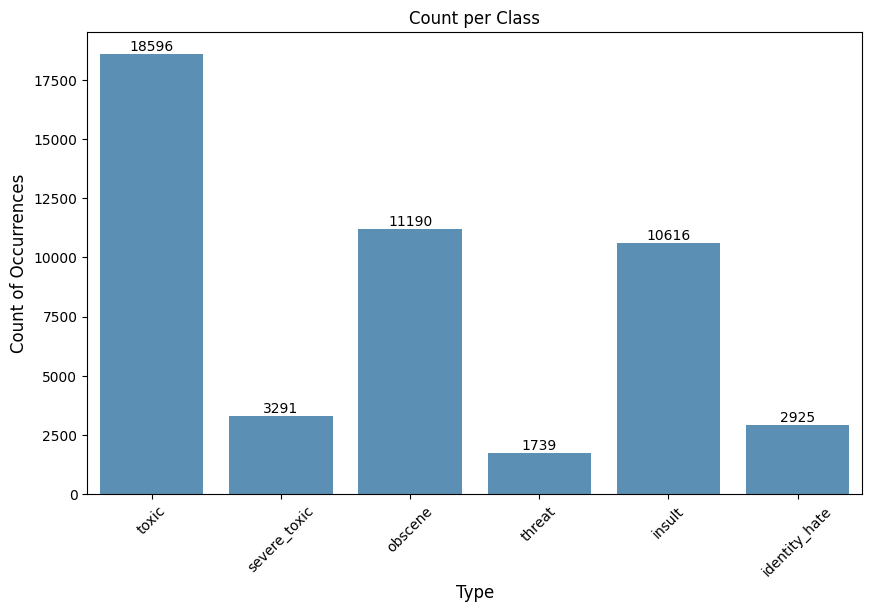

In [50]:
augmented_data_dist = augmented_data[toxicity_columns].sum()
plot_class_distribution(augmented_data_dist)

### Conclusion

The final class distribution shows a improvement in the representation of all categories after augmentation. While the toxic class remains the most frequent, other classes such as obscene, insult, and severe toxic have also seen notable increases. Importantly, the threat class, though still relatively less frequent, has been considerably augmented, helping to reduce the imbalance. This more balanced distribution should contribute to better model performance across all toxicity categories, especially for the previously underrepresented classes.

## Augmentation Outcome

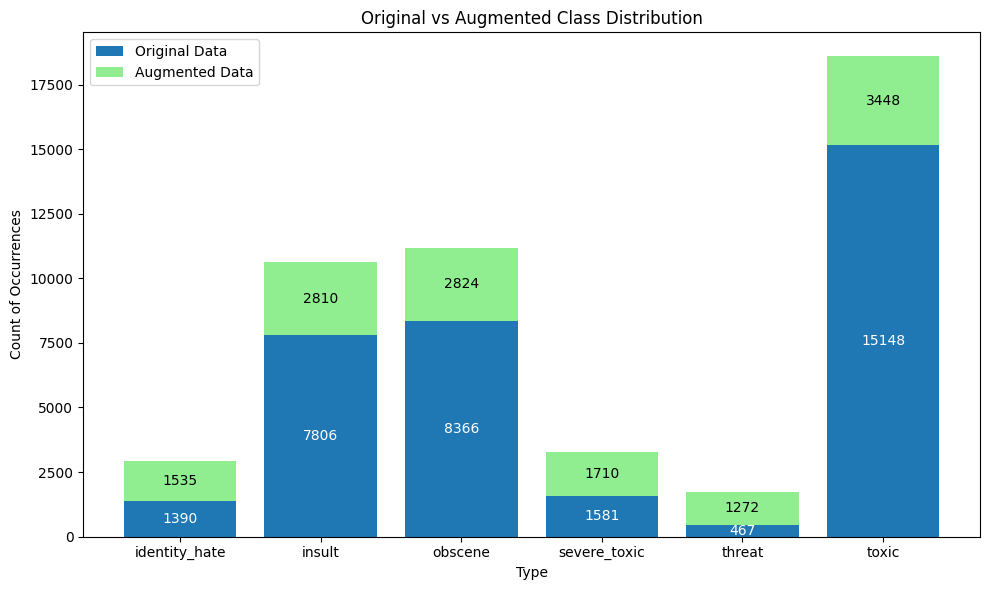

In [58]:
df_toxic_class_dist = df_toxic_class_dist.sort_index()
augmented_data_dist = augmented_data_dist.sort_index()
augmented_only_dist = augmented_data_dist - df_toxic_class_dist

fig, ax = plt.subplots(figsize=(10, 6))
labels = df_toxic_class_dist.index
ax.bar(labels, df_toxic_class_dist, label='Original Data', color='#1f77b4')
ax.bar(labels, augmented_only_dist, bottom=df_toxic_class_dist, label='Augmented Data', color='#90ee90')
ax.set_xlabel('Type')
ax.set_ylabel('Count of Occurrences')
ax.set_title('Original vs Augmented Class Distribution')
ax.legend()

for i, (orig, aug) in enumerate(zip(df_toxic_class_dist, augmented_only_dist)):
    ax.text(i, orig / 2, f'{orig}', ha='center', va='center', color='white')
    ax.text(i, orig + aug / 2, f'{aug}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

The graph above compares the original class distribution with the augmented data for each toxicity category. The augmentation process, particularly through backtranslation, has significantly increased the representation of underrepresented classes such as threat, identity hate, and severe toxic. While the larger classes like toxic, obscene, and insult also benefited from the augmentation, the focus was on balancing the dataset by improving the distribution of the smaller classes.

This approach ensures that the model is exposed to a wider variety of examples across all classes, which helps mitigate the challenges associated with class imbalance. The increase in the number of samples for the minority classes should enhance the model’s ability to accurately classify these categories, leading to more robust performance on the overall task. The final augmented dataset now provides a more balanced foundation for training, especially for those categories that were underrepresented in the original dataset.

In [60]:
merged_data = pd.concat([cleaned_data, augmented_data], ignore_index=True)
merged_data_dedup = merged_data.drop_duplicates(subset='cleaned_text', keep='first')
output_path = '../data/augmented_data.csv'
merged_data_dedup.to_csv(output_path, index=False)
print(f"Data saved to {output_path}")

Data saved to ../data/augmented_data.csv
